In [ ]:
# Insights on SAT Scores and Train accidents

This notebook shows you how to analyze train accidents based on accident reports 2015 national wide and SAT scores 2015. The analysis steps in the notebook show how you can use the information about accidents to learn more about the possible causes for collisions.

In [114]:
def set_hadoop_config(credentials_1):
    prefix = "fs.swift.service." + credentials['name'] 
    hconf = sc._jsc.hadoopConfiguration()
    hconf.set(prefix + ".auth.url", credentials['auth_url']+'/v3/auth/tokens')
    hconf.set(prefix + ".auth.endpoint.prefix", "endpoints")
    hconf.set(prefix + ".tenant", credentials['project_id'])
    hconf.set(prefix + ".username", credentials['user_id'])
    hconf.set(prefix + ".password", credentials['password'])
    hconf.setInt(prefix + ".http.port", 8080)
    hconf.set(prefix + ".region", credentials['region'])
    hconf.setBoolean(prefix + ".public", True)

In [115]:
credentials = {
  'auth_url':'https://identity.open.softlayer.com',
  'project':'object_storage_3af148c2_ad8a_4e20_950b_52ddebd2c9af',
  'project_id':'f6f24a60a7554abf9297467b358c8b1c',
  'region':'dallas',
  'user_id':'2fb9d812f4174bb8a4c8f274e8198446',
  'domain_id':'c76dcd603e2f49d08f1dfae089626a65',
  'domain_name':'1141927',
  'username':'admin_1fec61fc032767652786d0994956536d3a873a75',
  'password':"""WqWsj18I=]DwMN34""",
  'filename':'sat15.csv',
  'container':'notebooks',
  'tenantId':'s303-52812df91a63ae-4f6a0a5a8427'
}

In [116]:
credentials['name'] = 'keystone'
set_hadoop_config(credentials)

In [165]:
from __future__ import division
import numpy as np

from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)

# adding the PySpark modul to SparkContext
sc.addPyFile("https://raw.githubusercontent.com/seahboonsiew/pyspark-csv/master/pyspark_csv.py")
import pyspark_csv as pycsv

satscores = sc.textFile("swift://" + credentials['container'] + "." + credentials['name'] + "/sat15.csv")

def skip_header(idx, iterator):
    if (idx == 0):
        next(iterator)
    return iterator

score_header = satscores.first()


score_header_list = score_header.split(",")
score_body = satscores.mapPartitionsWithIndex(skip_header)


# create Spark DataFrame using pyspark-csv
sat_df = pycsv.csvToDataFrame(sqlContext, score_body, sep=",", columns=score_header_list)
sat_df.cache()

DataFrame[cds: int, rtype: string, sname: string, dname: string, cname: string, enroll12: int, NumTstTakr: int, AvgScrRead: string, AvgScrMath: string, AvgScrWrite: string, NumGE1500: string, PctGE1500: string]

In [166]:
# Python expressions in a code cell will be outputted after computation
sat_df.printSchema()

root
 |-- cds: integer (nullable = true)
 |-- rtype: string (nullable = true)
 |-- sname: string (nullable = true)
 |-- dname: string (nullable = true)
 |-- cname: string (nullable = true)
 |-- enroll12: integer (nullable = true)
 |-- NumTstTakr: integer (nullable = true)
 |-- AvgScrRead: string (nullable = true)
 |-- AvgScrMath: string (nullable = true)
 |-- AvgScrWrite: string (nullable = true)
 |-- NumGE1500: string (nullable = true)
 |-- PctGE1500: string (nullable = true)



In [169]:
sat_df.select("rtype").show()


+-----+
|rtype|
+-----+
|    X|
|    C|
|    D|
|    S|
|    S|
|    S|
|    D|
|    S|
|    S|
|    S|
|    S|
|    S|
|    S|
|    S|
|    D|
|    S|
|    D|
|    S|
|    S|
|    S|
+-----+
only showing top 20 rows



In [156]:
sat_df.count()

2331

In [193]:
district = sat_df.filter("rtype ='S'")
district.show()

+----------+-----+--------------------+--------------------+-------+--------+----------+----------+----------+-----------+---------+---------+
|       cds|rtype|               sname|               dname|  cname|enroll12|NumTstTakr|AvgScrRead|AvgScrMath|AvgScrWrite|NumGE1500|PctGE1500|
+----------+-----+--------------------+--------------------+-------+--------+----------+----------+----------+-----------+---------+---------+
| 658482059|    S| FAME Public Charter|Alameda County Of...|Alameda|      62|        17|       503|       546|        505|        9|    52.94|
| 658484831|    S|Envision Academy ...|Alameda County Of...|Alameda|      75|        71|       397|       387|        395|        5|     7.04|
| 658490713|    S|Aspire California...|Alameda County Of...|Alameda|      61|         0|        NA|        NA|         NA|       NA|       NA|
| 577370401|    S|Alameda Science a...|     Alameda Unified|Alameda|      36|        36|       562|       590|        555|       29|    80.56|

In [194]:
sat_county = district.groupBy("cname").count()
sat_county.show()

+-----------+-----+
|      cname|count|
+-----------+-----+
|       Inyo|    9|
|     Shasta|   17|
|     Orange|   90|
|   Mariposa|    2|
|     Placer|   25|
|     Tehama|    4|
|       Yolo|    9|
|      Butte|   17|
|     Colusa|    6|
|    Ventura|   34|
|    Trinity|    3|
|Santa Clara|   60|
|   Humboldt|   15|
|       Lake|    5|
|  San Mateo|   25|
|     Fresno|   60|
|   Siskiyou|    8|
|    Alameda|   74|
|Los Angeles|  406|
|       Yuba|    7|
+-----------+-----+
only showing top 20 rows



In [189]:
!pip install --user seaborn

In [190]:
%matplotlib inline

import matplotlib.pyplot as plt
# matplotlib.patches allows us create colored patches, we can use for legends in plots
import matplotlib.patches as mpatches
# seaborn also builds on matplotlib and adds graphical features and new plot types
import seaborn as sns
import pandas as pd

In [195]:
refine_county = sat_county.filter("count > 10")
refine_county.show()

+-------------+-----+
|        cname|count|
+-------------+-----+
|       Shasta|   17|
|       Orange|   90|
|       Placer|   25|
|        Butte|   17|
|      Ventura|   34|
|  Santa Clara|   60|
|     Humboldt|   15|
|    San Mateo|   25|
|       Fresno|   60|
|      Alameda|   74|
|  Los Angeles|  406|
|       Sonoma|   27|
|       Tulare|   35|
|San Francisco|   27|
|        Marin|   12|
|       Solano|   13|
| Contra Costa|   43|
|   Sacramento|   68|
|       Madera|   14|
|         Kern|   40|
+-------------+-----+
only showing top 20 rows



In [200]:
import pandas as pd
schoolDf = refine_county.orderBy(("count"), ("cname")).toPandas()


In [ ]:
# This is the graph plotted between the Counties in California and number of schools conducting SAT exams in each county

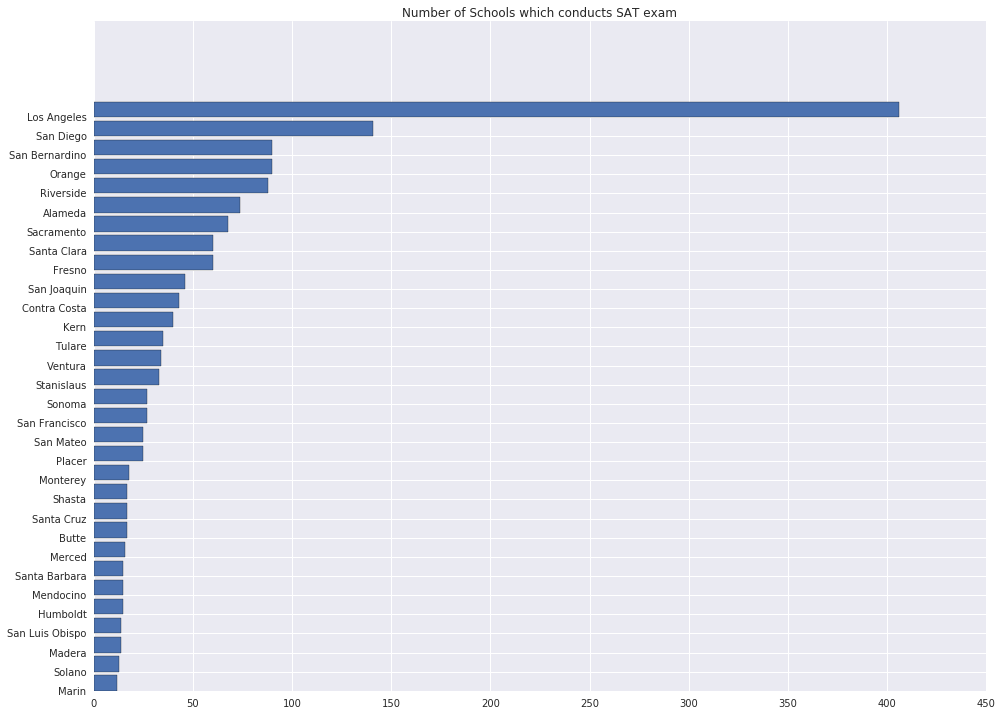

In [218]:
# The data
values = schoolDf['count']
labels = schoolDf['cname']

# The format
plt.gcf().set_size_inches(16, 12, forward=True)
plt.title('Number of Schools which conducts SAT exam')

# Barh is a horizontal bar chart with values (x axis) and labels (y axis)
plt.barh(range(len(values)), values)
plt.yticks(range(len(values)), labels)

# Print the plot
plt.show()

In [ ]:
## This is train crash data  of 2015

In [ ]:
credentials_2 = {
  'auth_url':'https://identity.open.softlayer.com',
  'project':'object_storage_3af148c2_ad8a_4e20_950b_52ddebd2c9af',
  'project_id':'f6f24a60a7554abf9297467b358c8b1c',
  'region':'dallas',
  'user_id':'2fb9d812f4174bb8a4c8f274e8198446',
  'domain_id':'c76dcd603e2f49d08f1dfae089626a65',
  'domain_name':'1141927',
  'username':'admin_1fec61fc032767652786d0994956536d3a873a75',
  'password':"""WqWsj18I=]DwMN34""",
  'filename':'traincrashes.csv',
  'container':'notebooks',
  'tenantId':'s303-52812df91a63ae-4f6a0a5a8427'
}

In [220]:
from __future__ import division
import numpy as np

from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)

# adding the PySpark modul to SparkContext
sc.addPyFile("https://raw.githubusercontent.com/seahboonsiew/pyspark-csv/master/pyspark_csv.py")
import pyspark_csv as pycsv

collisions = sc.textFile("swift://" + credentials['container'] + "." + credentials['name'] + "/traincrashes.csv")

def skip_header(idx, iterator):
    if (idx == 0):
        next(iterator)
    return iterator

train_collision_header = satscores.first()


train_collision_header_list = train_collision_header.split("|")
train_body = collisions.mapPartitionsWithIndex(skip_header)


# create Spark DataFrame using pyspark-csv
train_collision_df = pycsv.csvToDataFrame(sqlContext, train_body, sep="|", columns=train_collision_header_list)
train_collision_df.cache()

DataFrame[Date: timestamp, City, State: string, Street: string, Railroad: string, Description: string]

In [223]:
train_collision_df.printSchema()
train_collision_df.show()

root
 |-- Date: timestamp (nullable = true)
 |-- City, State: string (nullable = true)
 |-- Street: string (nullable = true)
 |-- Railroad: string (nullable = true)
 |-- Description: string (nullable = true)

+--------------------+--------------------+-------------------+--------------------+--------------------+
|                Date|         City, State|             Street|            Railroad|         Description|
+--------------------+--------------------+-------------------+--------------------+--------------------+
|2015-12-31 23:58:...|   CHESTER, VIRGINIA|     CENTRALIA ROAD|  CSX Transportation|Q43930 STRUCK A V...|
|2015-12-31 23:30:...|            ILLINOIS|           111TH ST|Wisconsin Central...|DRIVER FAILED TO ...|
|2015-12-31 17:35:...|           WISCONSIN|             CTH MM|Wisconsin Central...|VEHICLE TRAVELING...|
|2015-12-30 21:49:...|OLIVEHURST, CALIF...|       ALGODON ROAD|Union Pacific Rai...|VEHICLE BRAKES FA...|
|2015-12-30 14:28:...|   EAGLE LAKE, TEXAS|      

In [222]:
collision_by_railroad = train_collision_df.groupBy('Railroad').count()
collision_by_railroad.show()

+--------------------+-----+
|            Railroad|count|
+--------------------+-----+
|Rio Valley Switch...|    2|
|Finger Lakes Rail...|    1|
|South Florida Reg...|   10|
|Michigan Shore Ra...|    3|
|Utah Transit Auth...|    3|
|Alabama & Gulf Co...|    1|
|Southern New Jers...|    1|
|Wilmington Termin...|    1|
|BNSF Railway Company|  276|
|Eastern Idaho Rai...|    2|
|Indiana & Ohio Ra...|    5|
|Louisville & Indi...|    1|
|North Shore Railroad|    1|
|CHICAGO, FT. WAYN...|    1|
|New York, Susqueh...|    5|
|Georgia Central R...|    2|
|Ellis & Eastern C...|    1|
|Reading Blue Moun...|    1|
|Eastern Washingto...|    1|
|Western New York ...|    1|
+--------------------+-----+
only showing top 20 rows



In [224]:
refine_collision_by_railroad = collision_by_railroad.filter("count > 10")
refine_collision_by_railroad.show()

+--------------------+-----+
|            Railroad|count|
+--------------------+-----+
|BNSF Railway Company|  276|
|Chicago, Central ...|   15|
|Florida East Coas...|   12|
|  CSX Transportation|  371|
|Consolidated Rail...|   18|
|Illinois Central ...|   40|
|Union Pacific Rai...|  366|
|Wisconsin Central...|   26|
|Canadian Pacific ...|   32|
|Norfolk Southern ...|  328|
|Long Island Rail ...|   12|
|Kansas City South...|   57|
|Northeast IL Regi...|   12|
|Amtrak (National ...|  145|
+--------------------+-----+



In [ ]:
# This graph plots the graph between the railroad company and the total number of collisions by each railroad company.

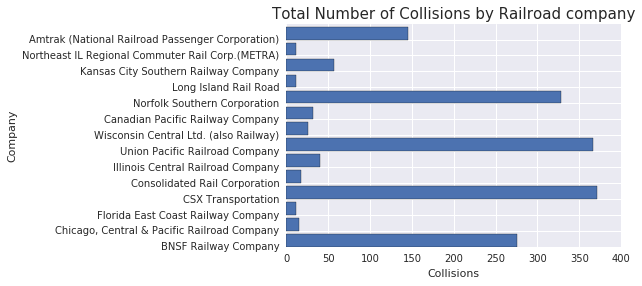

In [229]:
collisions_count = refine_collision_by_railroad.toPandas()
colors = ['g','0.75','y','k','b','r']
values = collisions_count['count']
labels = collisions_count['Railroad']

plt.xlabel('Collisions')
plt.ylabel('Company')
plt.title('Total Number of Collisions by Railroad company', size=15)
plt.barh(range(len(values)), values)
plt.yticks(range(len(values)), labels)

plt.show()